---
# YAML data for Mercury App
title: Prediction using CNN-LSTM
description: Stock Market Prediction using CNN-LSTM method (Primary notebook)
show-code: True
author: Aadhitya A
show-prompt: True
---

# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [2]:
# Done by Aadhitya A (2019506001)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Preprocessing and Analysis

In [3]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [4]:
import requests
import csv
from tqdm import tqdm

key = open('AV_API_Key.txt').read()

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "volume"]
    df['date'] = date
    return df

In [6]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 6386/6386 [00:58<00:00, 108.85it/s]

<bound method NDFrame.head of           open      high       low     close    volume        date
0     241.6900  245.2050  238.5000  243.8700   9580084  2025-03-21
1     244.2400  246.8000  237.2240  243.3200   7026796  2025-03-20
2     248.3300  253.6600  246.6400  252.2900   3853598  2025-03-19
3     252.5100  252.5700  245.1200  246.9500   4172239  2025-03-18
4     249.2500  254.6300  249.0000  252.9700   3234149  2025-03-17
...        ...       ...       ...       ...       ...         ...
6381   92.7500   92.9400   90.1900   90.2500  13737600  1999-11-05
6382   94.4400   94.4400   90.0000   91.5600  16697600  1999-11-04
6383   95.8700   95.9400   93.5000   94.3700  10369100  1999-11-03
6384   96.7500   96.8100   93.6900   94.8100  11105400  1999-11-02
6385   98.5000   98.8100   96.3700   96.7500   9551800  1999-11-01

[6386 rows x 6 columns]>


Then the datasets are loaded

In [7]:
# For data preprocessing and analysis part
data = pd.read_csv('./data/NASDAQ/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
#data = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 174.6+ KB


In [9]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [10]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

Filling null columns with mean values....

In [11]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


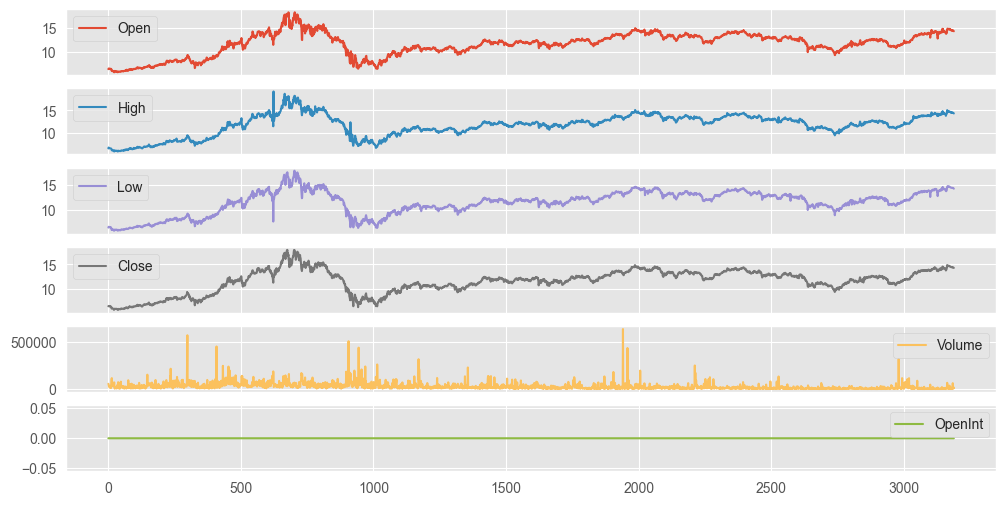

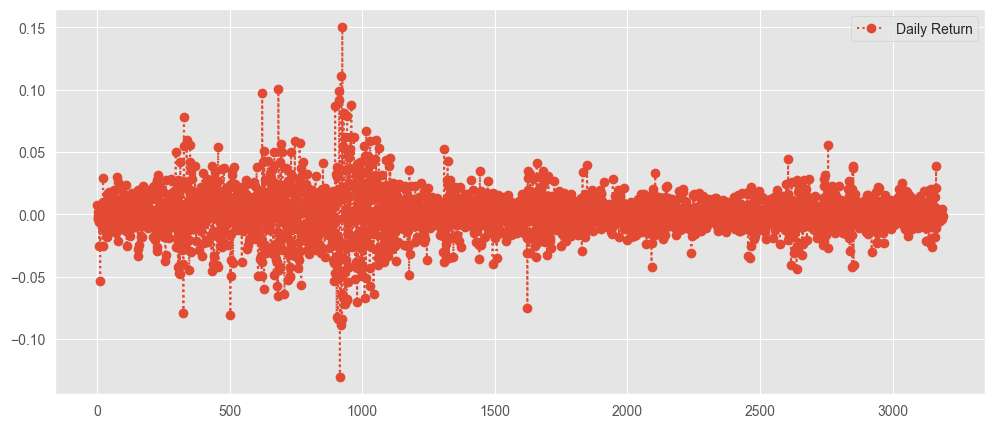

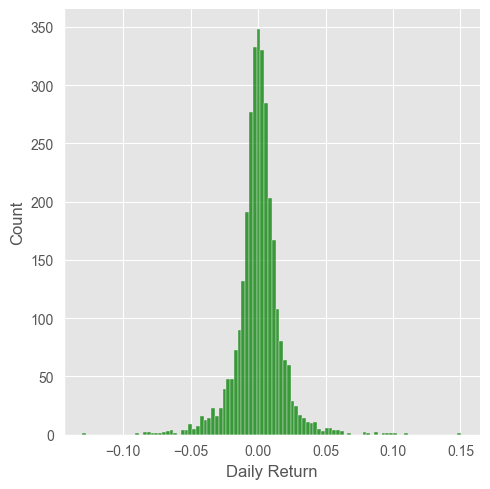

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
OpenInt            0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

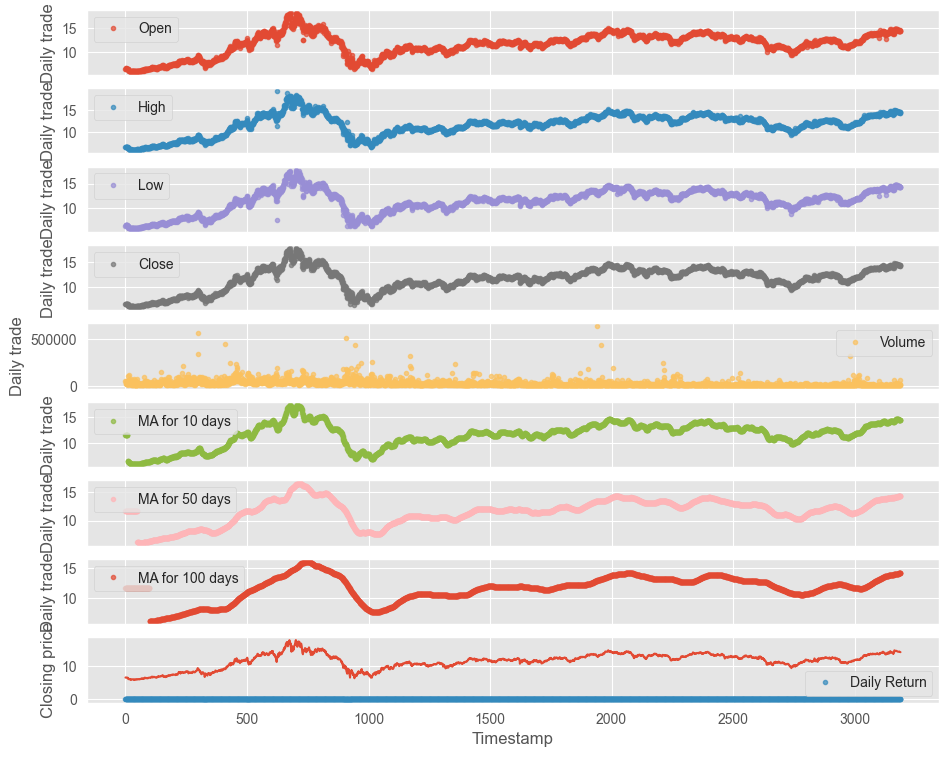

In [12]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

data.reset_index(drop=True, inplace=True)
data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

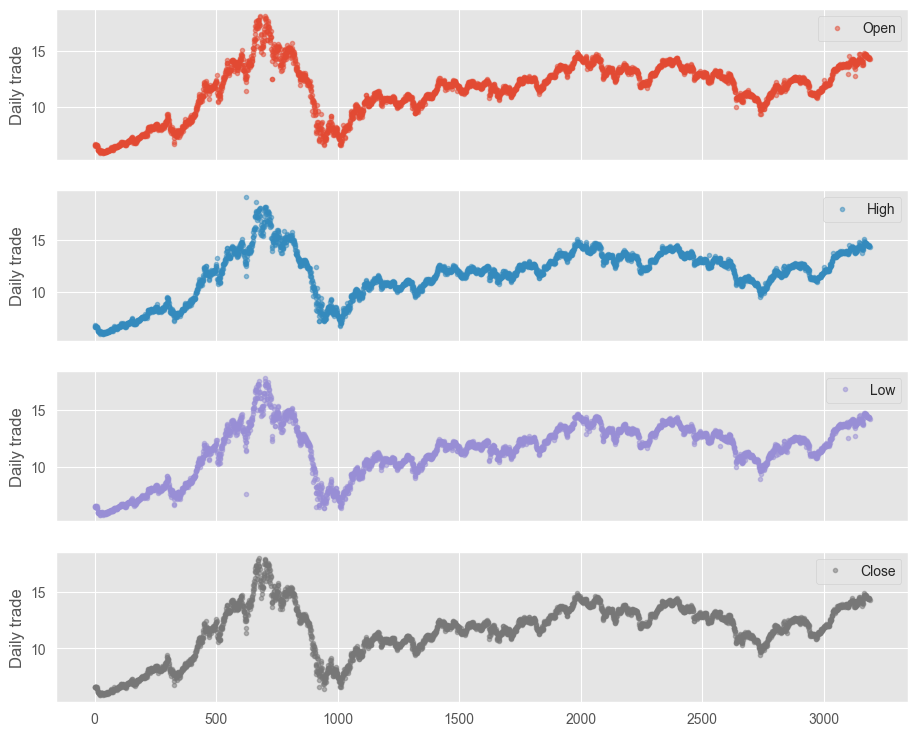

In [13]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

,count,mean,std,min,25%,50%,75%,max
Open,3190.0,11.599416,2.350376,5.860300,10.534000,11.981000,13.271000,18.130000
High,3190.0,11.712848,2.365621,5.905000,10.655000,12.067000,13.386750,19.151000
Low,3190.0,11.484610,2.327065,5.834700,10.413750,11.899000,13.189000,17.842000
Close,3190.0,11.605599,2.341989,5.841100,10.554000,11.988500,13.295750,17.925000
Volume,3190.0,28444.870846,37525.175821,106.000000,8147.750000,17741.500000,36167.250000,634041.000000
OpenInt,3190.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MA for 10 days,3190.0,11.608780,2.321162,5.963080,10.577125,11.962700,13.297200,17.329400
MA for 50 days,3190.0,11.625272,2.231059,6.037646,10.591696,11.933450,13.269480,16.618460
MA for 100 days,3190.0,11.649354,2.113346,6.221377,10.632551,11.876775,13.200810,16.042560
Daily Return,3190.0,0.000388,0.017010,-0.130345,-0.006439,0.000484,0.007807,0.150503


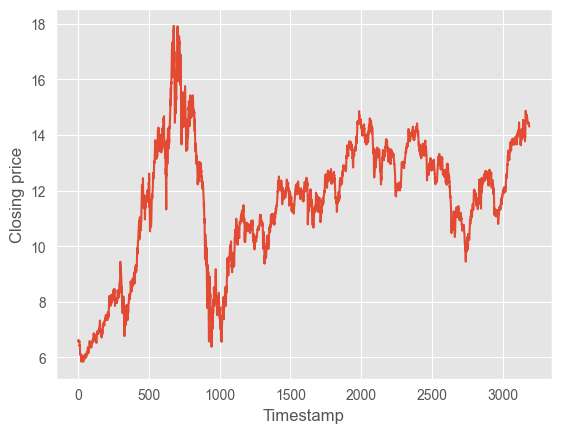

In [14]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [15]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [16]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40


c:\Users\yuvbo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0137 - mae: 0.0838 - mse: 0.0137 - val_loss: 0.0038 - val_mae: 0.0460 - val_mse: 0.0038
Epoch 2/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - mae: 0.0454 - mse: 0.0038 - val_loss: 0.0026 - val_mae: 0.0374 - val_mse: 0.0026
Epoch 3/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mae: 0.0379 - mse: 0.0026 - val_loss: 0.0031 - val_mae: 0.0411 - val_mse: 0.0031
Epoch 4/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0369 - mse: 0.0025 - val_loss: 0.0022 - val_mae: 0.0333 - val_mse: 0.0022
Epoch 5/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0358 - mse: 0.0025 - val_loss: 0.0024 - val_mae: 0.0354 - val_mse: 0.0024
Epoch 6/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - mae: 0.0333 - mse: 0.0021 - val_loss: 0.0026 - val_mae: 0.0370 - val_mse: 0.0026
Epoch 7/40
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - mae: 0.0355 - mse: 0.0023 - val_loss: 0.0025 - va

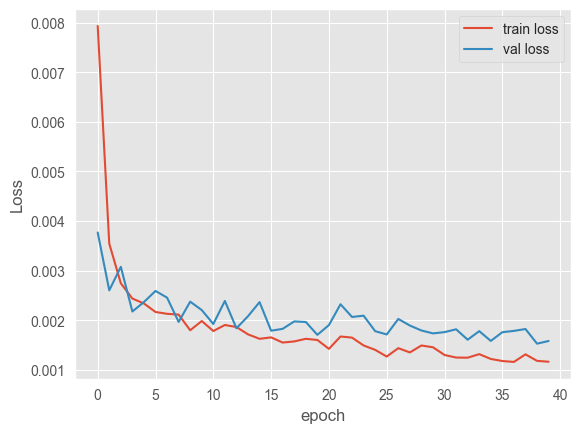

In [17]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

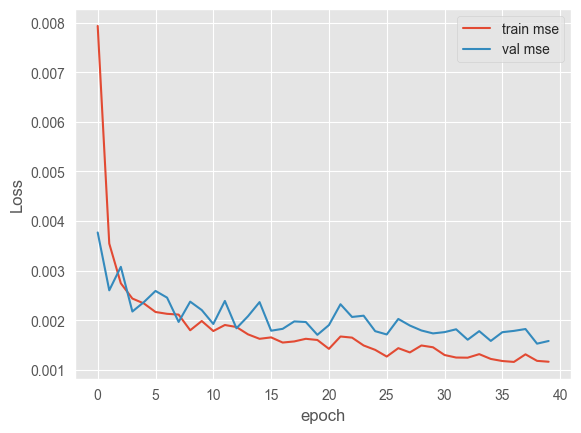

In [18]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

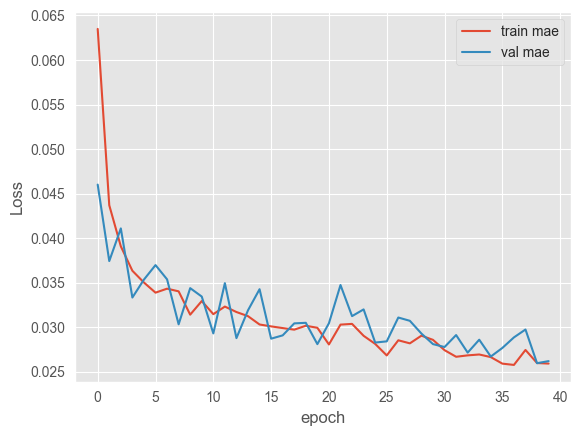

In [19]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [20]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 98, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 49, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 47, 128)     │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 23, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 21, 64)      │        24,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 10, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1, 640)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 200)         │       592,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650,205 (10.11 MB)

 Trainable params: 883,401 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,766,804 (6.74 MB)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [21]:
model.evaluate(test_X, test_Y)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0247 - mse: 0.0011


[0.001584061305038631, 0.001584061305038631, 0.026201877743005753]

In [22]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.928608
R2 Score: 0.928608
Max Error: 0.512206


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


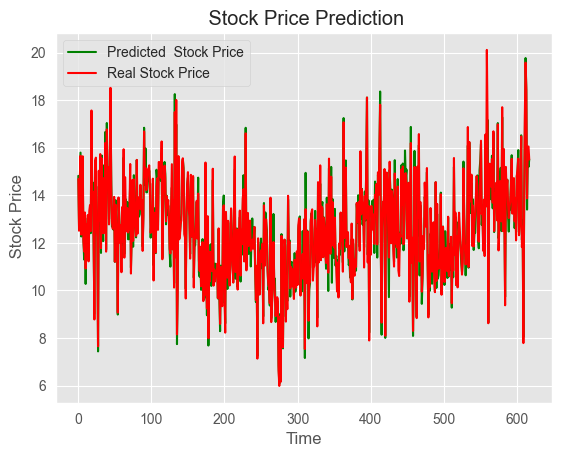

In [23]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [328]:
# First we need to save a model
model.save("model.h5")

In [329]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [330]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 1, 98, 64)         256       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 47, 128)        24704     
_________________________________________________________________
time_distributed_45 (TimeDis (None, 1, 23, 128)        0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 1, 21, 64)         24640     
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 10, 64)         0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 640)           

In [25]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

      Unnamed: 0    open     high      low   close    volume
0              0  241.69  245.205  238.500  243.87   9580084
1              1  244.24  246.800  237.224  243.32   7026796
2              2  248.33  253.660  246.640  252.29   3853598
3              3  252.51  252.570  245.120  246.95   4172239
4              4  249.25  254.630  249.000  252.97   3234149
...          ...     ...      ...      ...     ...       ...
6381        6381   92.75   92.940   90.190   90.25  13737600
6382        6382   94.44   94.440   90.000   91.56  16697600
6383        6383   95.87   95.940   93.500   94.37  10369100
6384        6384   96.75   96.810   93.690   94.81  11105400
6385        6385   98.50   98.810   96.370   96.75   9551800

[6386 rows x 6 columns]
5027
1257


In [26]:
model.evaluate(test_X, test_Y)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0386 - mse: 0.0030       


[0.0052174669690430164, 0.0052174669690430164, 0.05376975238323212]

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


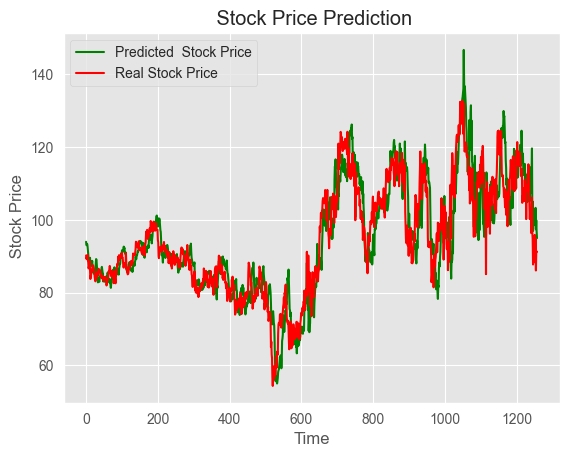

In [27]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [334]:
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

2021-12-28 04:28:46.375653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# EDA

This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

In [335]:
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5575 non-null   int64  
 1   open        5575 non-null   float64
 2   high        5575 non-null   float64
 3   low         5575 non-null   float64
 4   close       5575 non-null   float64
 5   volume      5575 non-null   int64  
 6   date        5575 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 305.0+ KB


In [336]:
dataX.head()

,Unnamed: 0,open,high,low,close,volume,date
0,0,130.63,131.6500,129.95,131.62,4294499,2021-12-27
1,1,130.00,130.9600,129.52,130.63,3649044,2021-12-23
2,2,129.06,129.7900,127.60,129.75,3923198,2021-12-22
3,3,127.66,129.3356,127.66,128.97,4855972,2021-12-21
4,4,125.72,127.2000,124.70,127.06,4941411,2021-12-20


In [337]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
19,19,118.62,119.610,117.53,118.50,8949795,2021-11-29
20,20,115.00,116.335,114.56,115.81,3322012,2021-11-26
21,21,116.16,117.270,116.08,116.73,3220802,2021-11-24
22,22,116.79,117.940,116.04,116.79,4914995,2021-11-23
23,23,116.00,118.810,115.19,116.47,6417218,2021-11-22
...,...,...,...,...,...,...,...
496,496,134.51,135.860,133.92,135.31,4345952,2020-01-08
497,497,133.69,134.960,133.40,134.19,3267592,2020-01-07
498,498,133.42,134.240,133.20,134.10,2421128,2020-01-06
499,499,133.57,134.860,133.56,134.34,2373470,2020-01-03


In [338]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
501,501,132.53,134.12,132.40,134.04,3777504,2019-12-31
502,502,135.20,135.30,132.50,132.81,4118929,2019-12-30
503,503,135.00,135.75,134.87,135.27,2752185,2019-12-27
504,504,134.98,135.31,134.65,134.91,2129654,2019-12-26
505,505,135.61,135.62,134.61,134.98,1202087,2019-12-24
...,...,...,...,...,...,...,...
999,999,162.66,163.91,161.70,163.47,5101023,2018-01-08
1000,1000,162.44,162.90,161.10,162.49,5162075,2018-01-05
1001,1001,159.65,162.32,159.37,161.70,7363843,2018-01-04
1002,1002,157.34,159.81,156.33,158.49,9439063,2018-01-03


In [339]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02
mean,259.500000,129.382080,130.691720,128.092867,129.364751,5.454950e+06
std,139.285678,11.382857,11.114856,11.592091,11.353678,3.339331e+06
min,19.000000,94.600000,97.740000,90.560000,94.770000,1.761122e+06
25%,139.250000,121.250000,122.623500,120.102500,121.105000,3.644222e+06
50%,259.500000,126.325000,127.320000,125.045000,126.160000,4.655173e+06
75%,379.750000,139.672500,140.467500,138.757500,139.572500,6.115408e+06
max,500.000000,156.820000,158.750000,155.420000,156.760000,3.806353e+07


In [340]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,752.000000,140.470239,141.512740,139.348929,140.416143,4.590926e+06
std,145.347859,11.156349,11.144803,11.149435,11.121441,2.880224e+06
min,501.000000,108.000000,111.000000,105.940000,107.570000,1.202087e+06
25%,626.500000,134.485000,135.305000,133.570000,134.360000,3.067226e+06
50%,752.000000,140.720000,141.780000,139.790000,140.850000,3.783614e+06
75%,877.500000,146.635000,147.300000,145.540000,146.385000,5.033500e+06
max,1003.000000,170.000000,171.130000,168.150000,169.120000,2.206367e+07


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


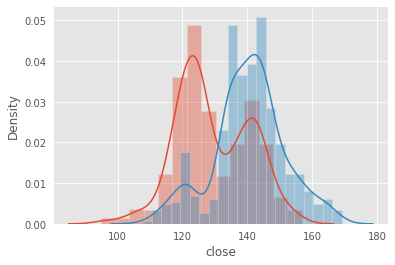

In [341]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

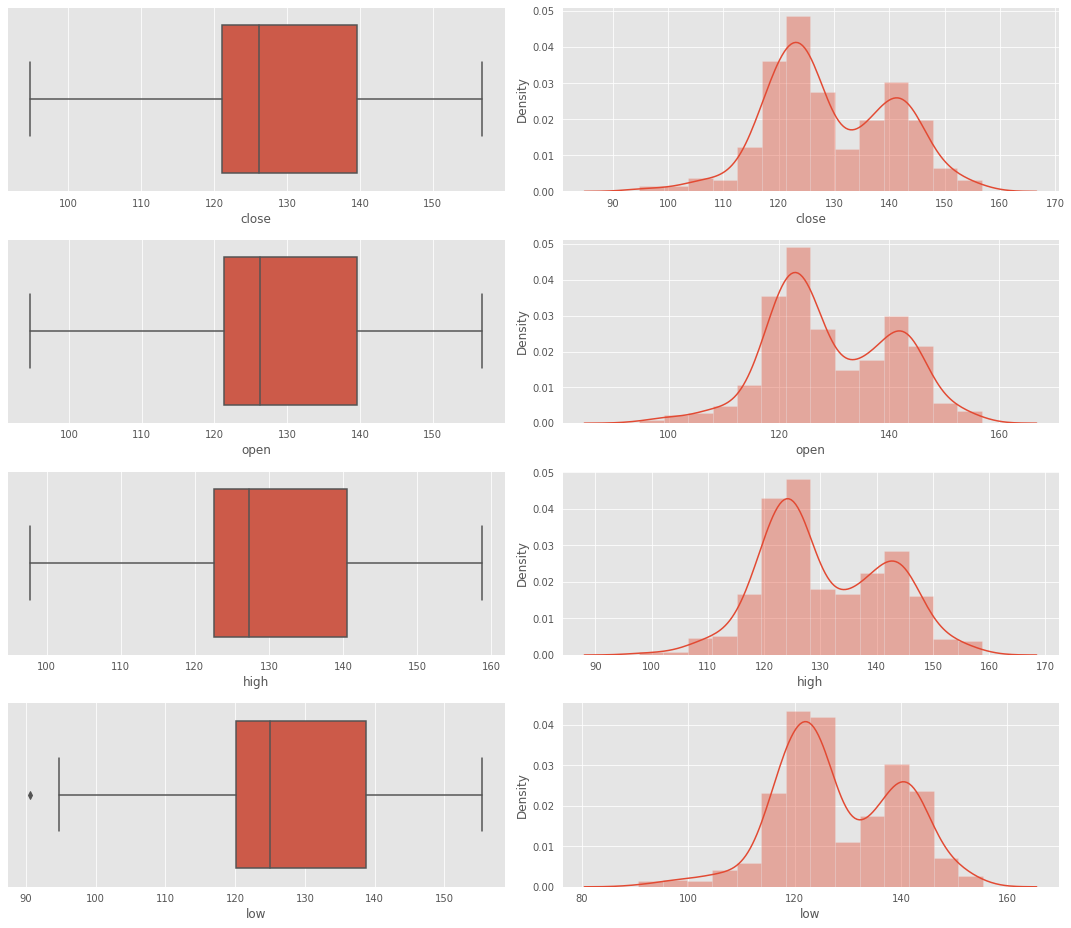

In [342]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

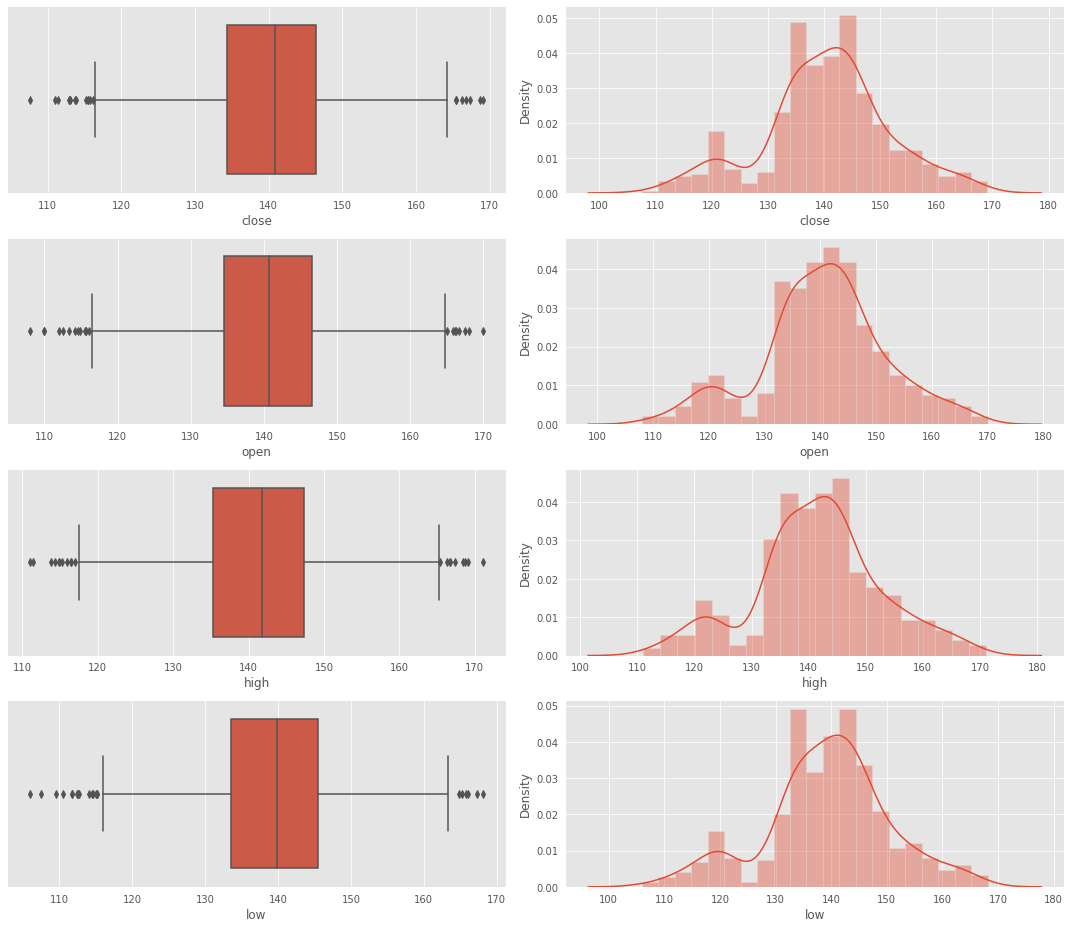

In [343]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

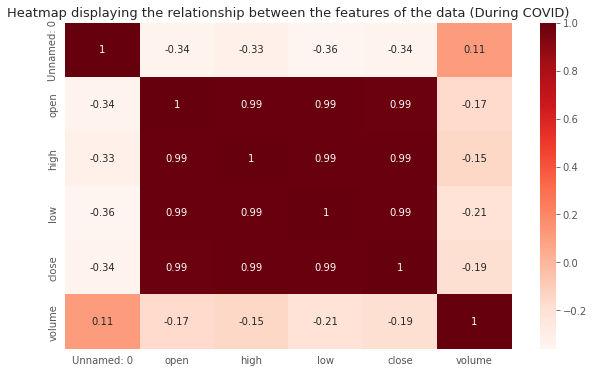

In [344]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

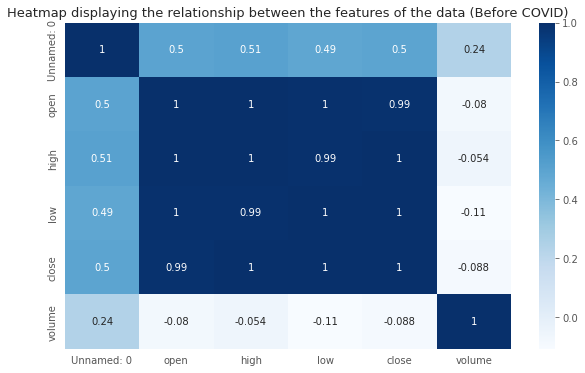

In [345]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

In [346]:
# For other company....

# UNCOMMENT IF NEEDED...
#cv2 = request_stock_price_list('RELIANCE.BSE', 'full', key)
#print(cv2.head)
#cv2.to_csv('data2.csv')

dataX = pd.read_csv('./data2.csv')
dataY = pd.read_csv('./data2.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184 entries, 0 to 4183
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4184 non-null   int64  
 1   open        4184 non-null   float64
 2   high        4184 non-null   float64
 3   low         4184 non-null   float64
 4   close       4184 non-null   float64
 5   volume      4184 non-null   int64  
 6   date        4184 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 228.9+ KB


In [347]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
20,20,2412.0000,2500.0000,2400.0000,2442.5000,451870,2021-11-29
21,21,2470.0000,2477.4500,2403.0000,2412.1499,397321,2021-11-26
22,22,2375.5000,2502.8000,2358.0000,2494.3999,476931,2021-11-25
23,23,2381.3999,2410.8501,2344.0000,2350.8999,1856369,2021-11-24
24,24,2339.0000,2401.5000,2309.3999,2386.1499,457139,2021-11-23
...,...,...,...,...,...,...,...
489,489,1519.9995,1533.9995,1514.4495,1525.0495,509038,2020-01-07
490,490,1526.9995,1527.9995,1497.4995,1501.4995,457443,2020-01-06
491,491,1534.3995,1541.2995,1523.3995,1537.2495,357456,2020-01-03
492,492,1513.9995,1540.7995,1512.9995,1535.3495,733200,2020-01-02


In [348]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
493,493,1516.0995,1527.3995,1505.3495,1509.6995,461171,2020-01-01
494,494,1544.6995,1544.6995,1509.0995,1514.0995,298520,2019-12-31
495,495,1542.9995,1546.9995,1528.2995,1544.1995,374974,2019-12-30
496,496,1524.9995,1545.7995,1521.4495,1542.1495,490080,2019-12-27
497,497,1545.9495,1553.2995,1510.9495,1515.9495,582675,2019-12-26
...,...,...,...,...,...,...,...
978,978,920.4997,925.8497,919.4497,922.9997,410556,2018-01-05
979,979,918.9997,921.7997,915.9997,920.2497,241196,2018-01-04
980,980,924.4497,927.1997,913.2997,916.3497,520663,2018-01-03
981,981,914.9997,919.1997,907.2497,911.3997,1779802,2018-01-02


In [349]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,256.500000,1953.239692,1977.124080,1925.387901,1949.614691,1.148593e+06
std,136.976275,378.827940,377.669256,377.601744,377.490721,6.773073e+06
min,20.000000,919.999700,951.999700,875.699700,883.849700,6.484700e+04
25%,138.250000,1731.837500,1754.662500,1714.137500,1729.987500,2.998212e+05
50%,256.500000,2013.850000,2045.550000,1990.925000,2007.300000,4.758745e+05
75%,374.750000,2170.825000,2194.675000,2139.500000,2167.175000,9.260610e+05
max,493.000000,2740.000000,2750.000000,2708.000000,2731.500000,1.187279e+08


In [350]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,490.00000,490.000000,490.000000,490.000000,490.000000,4.900000e+02
mean,737.50000,1182.485761,1194.496168,1168.685966,1181.144638,5.672558e+05
std,141.59508,185.207018,186.587684,182.842687,184.419946,5.363404e+05
min,493.00000,879.999700,895.999700,872.099700,882.799700,1.488160e+05
25%,615.25000,999.624700,1012.524700,990.762200,1002.462200,3.096382e+05
50%,737.50000,1207.499600,1223.449600,1195.999600,1210.324600,4.345385e+05
75%,859.75000,1297.999600,1314.699600,1283.862100,1296.824600,6.224218e+05
max,982.00000,1611.199500,1617.799500,1595.649500,1605.149500,6.718394e+06


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


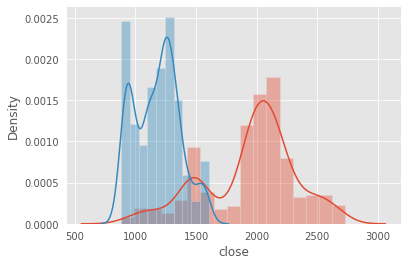

In [351]:
sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

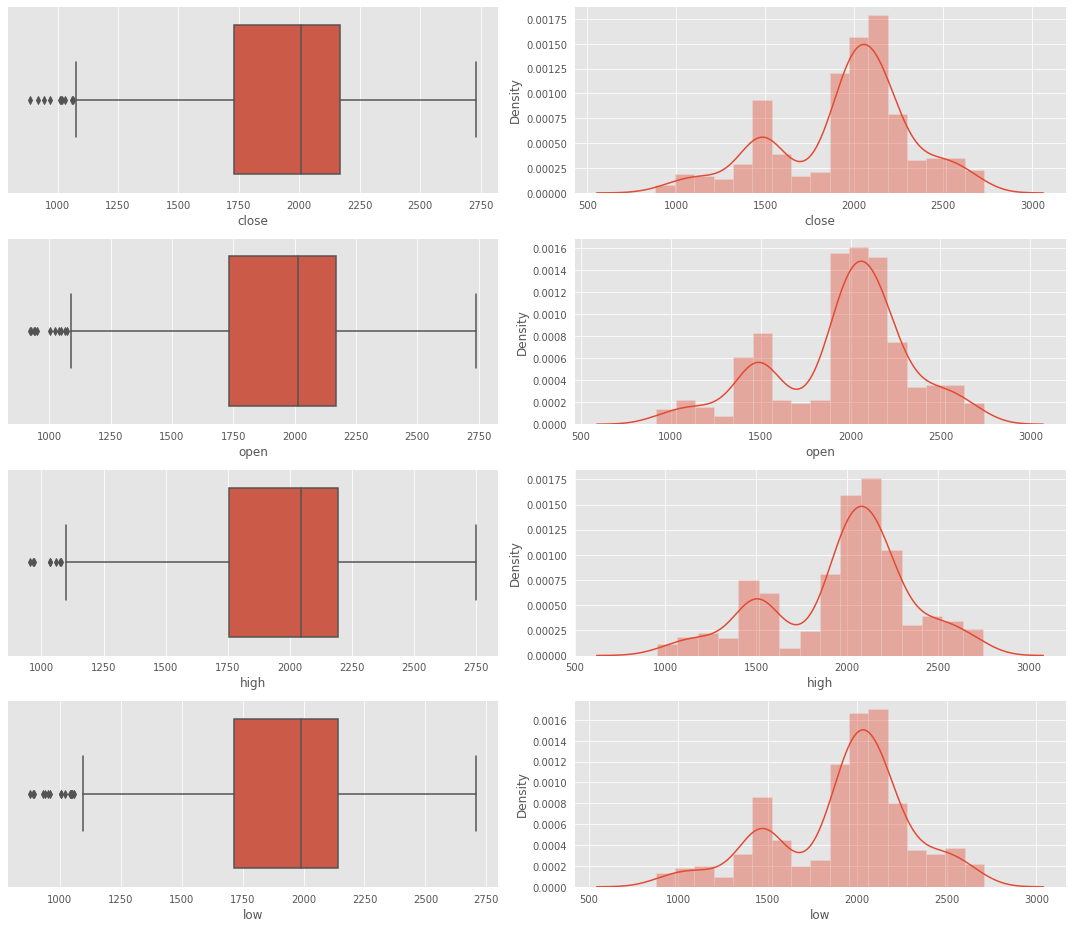

In [352]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

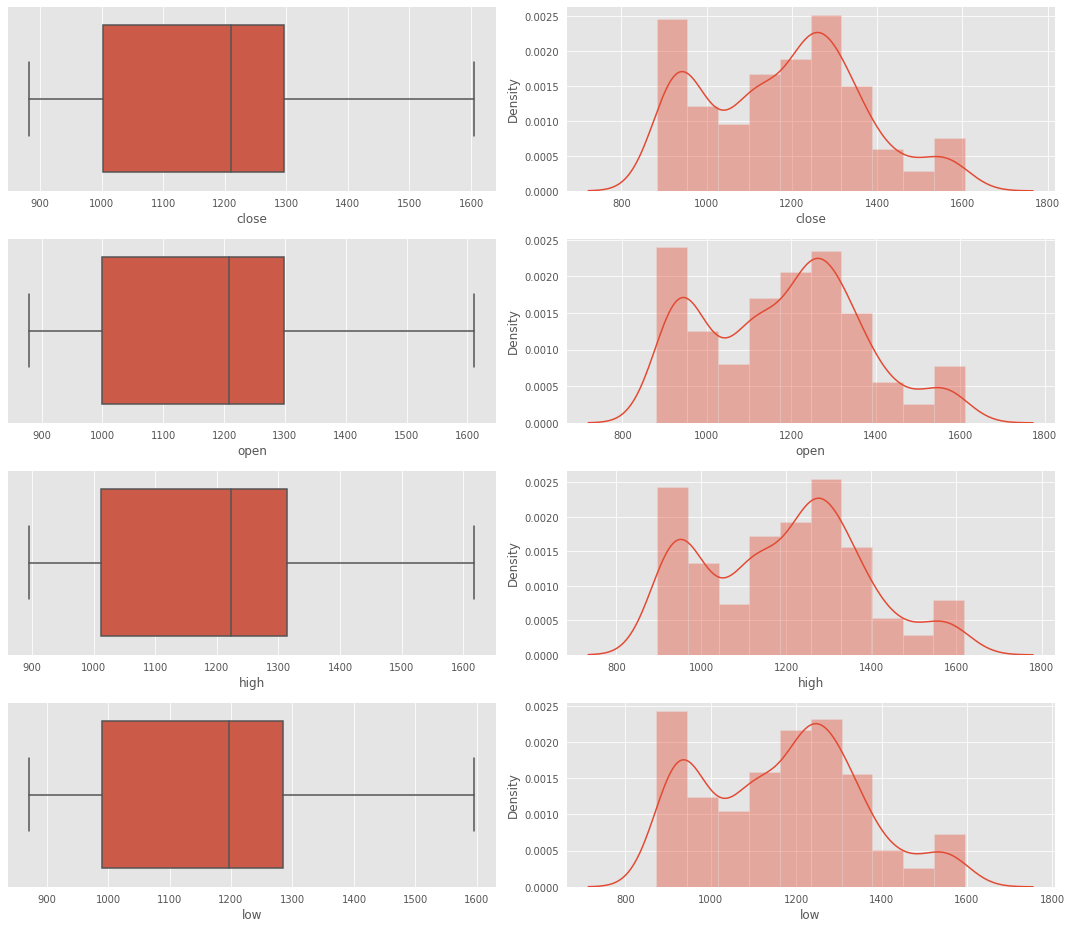

In [353]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

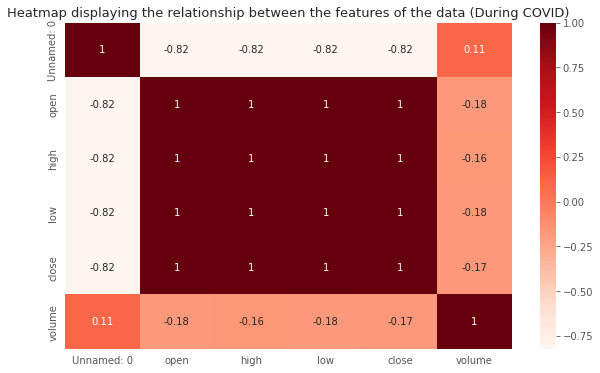

In [354]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

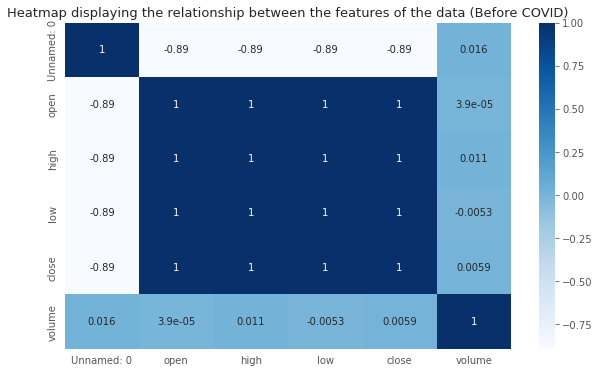

In [355]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

In [63]:
from sklearn.preprocessing import MinMaxScaler

def predict_next_day(model, data, window_size=100):
    last_window = data[['close']].iloc[-window_size:].values  # Get last window

    X = np.array(last_window).reshape(1, 1, window_size, 1)
    prediction_scaled = model.predict(X)[0][0]  # Get the prediction

    # **Inverse transform the prediction**
    predicted_price = scaler.inverse_transform([[prediction_scaled]])[0][0]

    return predicted_price


# Example usage:
data = pd.read_csv("data.csv")
scaler = MinMaxScaler(feature_range=(0, 1))
data[['close']] = scaler.fit_transform(data[['close']])  # Fit & transform
next_day_price = predict_next_day(model, data)
print(f"Predicted Next Day Price: {next_day_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Next Day Price: 85.88


In [45]:
data = pd.read_csv("data.csv")

print(data['close'].mean())

133.3691766050736


In [65]:
last_window = data[['close']].iloc[-window_size:].values  # Get last window

X = np.array(last_window).reshape(1, 1, window_size, 1)
prediction_scaled = model.predict(X)[0][0]  # Get the prediction

print([prediction_scaled])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.14693104]


In [76]:
import yfinance as yf
import pandas as pd
from fredapi import Fred
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize FRED API (use your API key)
fred = Fred(api_key='975495ba67994aa02bc411e69630453e')

# Define date range
start_date = '2010-01-01'
end_date = '2023-12-31'

# IBM stock data
ibm = yf.download('IBM', start=start_date, end=end_date)  # IBM stock price & volume
print("IBM Columns:", ibm.columns)

# IBM Option Chain for Implied Volatility
ticker = yf.Ticker('IBM')
options_dates = ticker.options
option_chain = ticker.option_chain(options_dates[0])  # Take nearest expiry
ibm_iv = option_chain.calls['impliedVolatility'].mean()  # Average IV from calls

# Market index (S&P 500)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)  # Market Index Return

# Sector ETF (Technology ETF XLK)
xlk = yf.download('XLK', start=start_date, end=end_date)  # Sector Performance Index

# VIX index (daily volatility measure)
vix = yf.download('^VIX', start=start_date, end=end_date)  # VIX (CBOE Volatility Index)

# Credit Spread proxy using BAA - AAA spread from FRED
baa_yield = fred.get_series('BAA10Y', observation_start=start_date, observation_end=end_date)  # BAA corporate bonds
aaa_yield = fred.get_series('AAA10Y', observation_start=start_date, observation_end=end_date)  # AAA corporate bonds
credit_spread = (baa_yield - aaa_yield).resample('D').ffill()  # Credit Spreads

# 10-Year Treasury Yield from FRED
treasury_yield = fred.get_series('GS10', observation_start=start_date, observation_end=end_date)  # Risk-free rate
treasury_yield = treasury_yield.resample('D').ffill()

# CPI data from FRED
cpi = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)  # Inflation proxy
cpi = cpi.resample('D').ffill()

# Align all data to the same date index
combined_data = pd.DataFrame(index=ibm.index)
combined_data['IBM_Close'] = ibm['Close']  # IBM Close
print("Latest IBM Close:", combined_data['IBM_Close'].iloc[-1])
combined_data['IBM_Volume'] = ibm['Volume']  # Trading Volume
print("Latest IBM Volume:", combined_data['IBM_Volume'].iloc[-1])
combined_data['SP500_Close'] = sp500['Close']  # Market Index Return
print("Latest SP500 Close:", combined_data['SP500_Close'].iloc[-1])
combined_data['XLK_Close'] = xlk['Close']  # Sector Performance Index
print("Latest XLK Close:", combined_data['XLK_Close'].iloc[-1])
combined_data['VIX'] = vix['Close']  # VIX
print("Latest VIX:", combined_data['VIX'].iloc[-1])
combined_data['Treasury_Yield'] = treasury_yield.reindex(ibm.index)  # Treasury Yield
print("Latest Treasury Yield:", combined_data['Treasury_Yield'].dropna().iloc[-1])
combined_data['CPI'] = cpi.reindex(ibm.index)  # CPI
print("Latest CPI:", combined_data['CPI'].dropna().iloc[-1])
combined_data['Credit_Spread'] = credit_spread.reindex(ibm.index)  # Credit Spread
print("Latest Credit Spread:", combined_data['Credit_Spread'].dropna().iloc[-1])
combined_data['Implied_Volatility'] = ibm_iv  # Static IV for now
print("Implied Volatility from Options Chain:", ibm_iv)

# Drop rows with missing values
combined_data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

IBM Columns: MultiIndex([( 'Close', 'IBM'),
            (  'High', 'IBM'),
            (   'Low', 'IBM'),
            (  'Open', 'IBM'),
            ('Volume', 'IBM')],
           names=['Price', 'Ticker'])



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Latest IBM Close: 156.79931640625
Latest IBM Volume: 2525600
Latest SP500 Close: 4769.830078125
Latest XLK Close: 191.16896057128906
Latest VIX: 12.449999809265137
Latest Treasury Yield: 4.02
Latest CPI: 308.735
Latest Credit Spread: 0.8400000000000001
Implied Volatility from Options Chain: 0.569304818725586


In [ ]:
# Cell 2: Calculate correlations with IBM returns

# Calculate IBM daily returns
combined_data['IBM_Returns'] = combined_data['IBM_Close'].pct_change()

# Calculate company-specific features
combined_data['IBM_Volatility'] = ibm['Adj Close'].pct_change().rolling(window=30).std()  # Historical Volatility
combined_data['IBM_Momentum'] = ibm['Adj Close'] / ibm['Adj Close'].shift(20) - 1  # Price Momentum (20-day)

# Calculate daily returns for other relevant factors
combined_data['SP500_Returns'] = combined_data['SP500_Close'].pct_change()
combined_data['XLK_Returns'] = combined_data['XLK_Close'].pct_change()
combined_data['VIX_Change'] = combined_data['VIX'].pct_change()
combined_data['Treasury_Yield_Change'] = combined_data['Treasury_Yield'].pct_change()
combined_data['CPI_Change'] = combined_data['CPI'].pct_change()
combined_data['Credit_Spread_Change'] = combined_data['Credit_Spread'].pct_change()
combined_data['Volume_Change'] = combined_data['IBM_Volume'].pct_change()

# Drop NA after pct_change
combined_data.dropna(inplace=True)

# Calculate correlation matrix
correlation_matrix = combined_data[[
    'IBM_Returns', 
    'SP500_Returns', 
    'XLK_Returns', 
    'VIX_Change', 
    'Treasury_Yield_Change', 
    'CPI_Change', 
    'Credit_Spread_Change',
    'IBM_Volatility',
    'IBM_Momentum',
    'Volume_Change'
]].corr()

# Show correlations specifically to IBM Returns
ibm_corr = correlation_matrix['IBM_Returns'].drop('IBM_Returns')

print("Correlation of external factors with IBM Returns:")
print(ibm_corr)

# Optional: Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
